

# Initial Setup



In [11]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [12]:
import os
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np

# Set the seed for random operations. 
# Letting experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED) 
np.random.seed(SEED)

# Get current working directory
cwd = os.getcwd()

In [13]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [14]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Dec  9 15:40:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Dataset Retrieval

In [146]:
# Option to set to true the first time to RETRIEVE the dataset and create the
# folder structure. If set to false it expects the dataset to be already 
# splitted and zipped in your drive in the directory "Challenge_2".
SPLIT_DATASET = True

# This option let you use your dataset_split.json file, that must be located in 
# your drive in the directory "Challenge_2", for the dataset split.
# Is considered only if SPLIT_DATASET == True since if SPLIT_DATASET == 
# False the dataset is expected to be already splitted and zipped in your
# drive in the directory "Challenge_2".
LOAD_FROM_JSON = False

### Cells executed if: SPLIT_DATASET = True 

In [147]:
if SPLIT_DATASET == True:
  ! unzip '/content/drive/My Drive/Challenge_2/Development_Dataset.zip'

Archive:  /content/drive/My Drive/Challenge_2/Development_Dataset.zip
  inflating: Development_Dataset/LICENSE.txt  
   creating: Development_Dataset/Test_Dev/
   creating: Development_Dataset/Test_Dev/Bipbip/
   creating: Development_Dataset/Test_Dev/Bipbip/Haricot/
   creating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00211.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00581.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00721.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00951.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_01341.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02421.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02781.jpg  
  inflati

In [148]:
# -----------------------------
# Create the dataset_split.json 
# -----------------------------
if SPLIT_DATASET == True and LOAD_FROM_JSON == False:

  from PIL import Image
  import json
  
  VALIDATION_SPLIT = 0.15

  split = {}
  split['training'] = {}
  split['validation'] = {}

  teams = ['Bipbip', 'Pead', 'Roseau', 'Weedelec']
  plants = ['Haricot', 'Mais']

  # Random seed for reproducibility
  np.random.seed(SEED)

  for t in teams:

    split['training'][t] = {}
    split['validation'][t] = {}

    for p in plants:

      split['training'][t][p] = []      
      split['validation'][t][p] = []

      image_filenames = os.listdir('/content/Development_Dataset/Training/' + t + '/' + p + '/' + 'Images')
      # Shuffle the images to get a random split
      np.random.shuffle(image_filenames)
          
      # Create training split
      for i in range(int(len(image_filenames) * (1 - VALIDATION_SPLIT))):
        image_name = image_filenames[i].split('.')
        split['training'][t][p].append(image_name)

      
      # Create validation split
      for j in range(i + 1, len(image_filenames)):
        image_name = image_filenames[j].split('.')
        split['validation'][t][p].append(image_name)

  with open(os.path.join(cwd, 'dataset_split.json'), 'w') as f:
    json.dump(split, f)

  ! cp '/content/dataset_split.json' '/content/drive/My Drive/Challenge_2/dataset_split.json'

In [149]:
# ------------------------------------------
# Create the splitted dataset directory tree 
# ------------------------------------------
if SPLIT_DATASET == True:
  import shutil
  
  # Use your dataset_split.json 
  # ---------------------------
  if LOAD_FROM_JSON == True:
    import json
    f = open('/content/drive/My Drive/Challenge_2/dataset_split.json')
    split = json.load(f) 
    ! cp '/content/drive/My Drive/Challenge_2/dataset_split.json' '/content/dataset_split.json'  
  # ---------------------------


  # Create the folder for the splitted dataset
  # ------------------------------------------
  ! mkdir '/content/Development_Dataset_15'

  ! mkdir '/content/Development_Dataset_15/training'
  ! mkdir '/content/Development_Dataset_15/training/images'
  ! mkdir '/content/Development_Dataset_15/training/masks'

  ! mkdir '/content/Development_Dataset_15/validation'
  ! mkdir '/content/Development_Dataset_15/validation/images'
  ! mkdir '/content/Development_Dataset_15/validation/masks'
  # ------------------------------------------

  teams = ['Bipbip', 'Pead', 'Roseau', 'Weedelec']
  plants = ['Haricot', 'Mais']

  for t in teams:
    for p in plants:

      for img_name in split['training'][t][p]:
        
        src_path = os.path.join(cwd, 'Development_Dataset/Training/' + t + '/' + p + '/' + 'Images', img_name[0] + '.' + img_name[1])
        dst_path = os.path.join(cwd, 'Development_Dataset_15/training/images')
        shutil.move(src_path, dst_path)

        src_path = os.path.join(cwd, 'Development_Dataset/Training/' + t + '/' + p + '/' + 'Masks', img_name[0] + '.png')
        dst_path = os.path.join(cwd, 'Development_Dataset_15/training/masks')
        shutil.move(src_path, dst_path)

      for img_name in split['validation'][t][p]:
    
        src_path = os.path.join(cwd, 'Development_Dataset/Training/' + t + '/' + p + '/' + 'Images', img_name[0] + '.' + img_name[1])
        dst_path = os.path.join(cwd, 'Development_Dataset_15/validation/images')
        shutil.move(src_path, dst_path)
    
        src_path = os.path.join(cwd, 'Development_Dataset/Training/' + t + '/' + p + '/' + 'Masks', img_name[0] + '.png')
        dst_path = os.path.join(cwd, 'Development_Dataset_15/validation/masks')
        shutil.move(src_path, dst_path)
  ! ls

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_05991.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_05991.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_00321.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_00321.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_03751.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_03751.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_08141.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_08141.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_01021.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_01021.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_00391.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_00391.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_04991.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_04991.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_07071.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_07071.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_02301.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_02301.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_05421.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_05421.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_05911.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_05911.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_05741.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_05741.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_07941.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_07941.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_04591.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_04591.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_05411.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_05411.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_03041.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_03041.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_05571.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_05571.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_08371.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_08371.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_07861.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_07861.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_02171.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_02171.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_06851.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_06851.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_02651.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_02651.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_01451.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_01451.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_07591.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_07591.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_06481.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_06481.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_02231.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_02231.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_05141.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_05141.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_03291.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_03291.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_01821.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_01821.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_01731.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_01731.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_06941.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_06941.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_06241.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_06241.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_04301.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_04301.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_06041.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_06041.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_01631.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_01631.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_07531.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_07531.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_05531.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_05531.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_01091.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_01091.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_07781.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_07781.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_03231.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_03231.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_03111.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_03111.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_06641.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_06641.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_02531.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_02531.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_08221.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_08221.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_03461.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_03461.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_01911.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_01911.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_07131.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_07131.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_03571.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_03571.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_01541.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_01541.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_05461.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_05461.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_06531.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_06531.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_03531.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_03531.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_03281.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_03281.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_03841.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_03841.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_04741.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_04741.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_00871.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_00871.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_05111.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_05111.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_04851.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_04851.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_04031.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_04031.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_00451.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_00451.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_00651.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_00651.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_07481.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_07481.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_05481.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_05481.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_05301.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_05301.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_06801.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_06801.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_05231.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_05231.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_06401.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_06401.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_01271.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_01271.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_03961.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_03961.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_05041.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_05041.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_06341.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_06341.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_00511.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_00511.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_04791.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_04791.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_04541.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_04541.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_00801.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_00801.png'

'/content/Development_Dataset_15/training/images/Bipbip_haricot_im_03481.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_haricot_im_03481.png'

'/content/Development_Dataset_15/validation/images/Bipbip_haricot_im_02351.jpg'

'/content/Development_Dataset_15/validation/masks/Bipbip_haricot_im_02351.png'

'/content/Development_Dataset_15/validation/images/Bipbip_haricot_im_07701.jpg'

'/content/Development_Dataset_15/validation/masks/Bipbip_haricot_im_07701.png'

'/content/Development_Dataset_15/validation/images/Bipbip_haricot_im_06151.jpg'

'/content/Development_Dataset_15/validation/masks/Bipbip_haricot_im_06151.png'

'/content/Development_Dataset_15/validation/images/Bipbip_haricot_im_05351.jpg'

'/content/Development_Dataset_15/validation/masks/Bipbip_haricot_im_05351.png'

'/content/Development_Dataset_15/validation/images/Bipbip_haricot_im_06901.jpg'

'/content/Development_Dataset_15/validation/masks/Bipbip_haricot_im_06901.png'

'/content/Development_Dataset_15/validation/images/Bipbip_haricot_im_03611.jpg'

'/content/Development_Dataset_15/validation/masks/Bipbip_haricot_im_03611.png'

'/content/Development_Dataset_15/validation/images/Bipbip_haricot_im_05361.jpg'

'/content/Development_Dataset_15/validation/masks/Bipbip_haricot_im_05361.png'

'/content/Development_Dataset_15/validation/images/Bipbip_haricot_im_07011.jpg'

'/content/Development_Dataset_15/validation/masks/Bipbip_haricot_im_07011.png'

'/content/Development_Dataset_15/validation/images/Bipbip_haricot_im_08071.jpg'

'/content/Development_Dataset_15/validation/masks/Bipbip_haricot_im_08071.png'

'/content/Development_Dataset_15/validation/images/Bipbip_haricot_im_04401.jpg'

'/content/Development_Dataset_15/validation/masks/Bipbip_haricot_im_04401.png'

'/content/Development_Dataset_15/validation/images/Bipbip_haricot_im_03411.jpg'

'/content/Development_Dataset_15/validation/masks/Bipbip_haricot_im_03411.png'

'/content/Development_Dataset_15/validation/images/Bipbip_haricot_im_06691.jpg'

'/content/Development_Dataset_15/validation/masks/Bipbip_haricot_im_06691.png'

'/content/Development_Dataset_15/validation/images/Bipbip_haricot_im_06101.jpg'

'/content/Development_Dataset_15/validation/masks/Bipbip_haricot_im_06101.png'

'/content/Development_Dataset_15/validation/images/Bipbip_haricot_im_07371.jpg'

'/content/Development_Dataset_15/validation/masks/Bipbip_haricot_im_07371.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_03811.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_03811.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_03871.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_03871.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_05801.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_05801.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_09921.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_09921.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_08121.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_08121.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_09641.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_09641.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_09841.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_09841.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_08381.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_08381.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_06691.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_06691.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_09231.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_09231.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_08511.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_08511.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_02461.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_02461.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_06141.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_06141.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_10231.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_10231.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_10161.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_10161.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_01461.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_01461.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_10691.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_10691.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_01751.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_01751.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_03391.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_03391.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_01561.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_01561.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_04621.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_04621.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_02371.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_02371.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_07041.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_07041.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_02891.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_02891.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_02731.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_02731.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_06961.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_06961.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_01601.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_01601.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_07181.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_07181.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_07831.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_07831.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_10851.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_10851.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_03691.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_03691.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_05031.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_05031.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_04781.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_04781.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_03181.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_03181.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_10301.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_10301.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_02411.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_02411.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_08441.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_08441.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_01391.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_01391.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_07271.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_07271.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_10081.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_10081.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_02281.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_02281.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_03121.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_03121.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_09501.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_09501.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_08661.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_08661.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_01871.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_01871.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_02691.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_02691.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_07531.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_07531.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_05451.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_05451.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_08061.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_08061.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_06071.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_06071.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_03511.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_03511.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_04501.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_04501.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_07991.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_07991.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_04671.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_04671.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_08811.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_08811.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_06541.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_06541.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_01681.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_01681.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_03231.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_03231.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_10771.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_10771.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_08731.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_08731.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_05871.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_05871.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_08321.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_08321.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_03581.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_03581.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_02511.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_02511.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_07351.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_07351.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_02941.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_02941.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_09711.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_09711.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_04031.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_04031.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_05221.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_05221.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_08261.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_08261.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_10371.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_10371.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_03921.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_03921.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_02151.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_02151.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_08581.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_08581.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_05691.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_05691.png'

'/content/Development_Dataset_15/training/images/Bipbip_mais_im_07451.jpg'

'/content/Development_Dataset_15/training/masks/Bipbip_mais_im_07451.png'

'/content/Development_Dataset_15/validation/images/Bipbip_mais_im_11121.jpg'

'/content/Development_Dataset_15/validation/masks/Bipbip_mais_im_11121.png'

'/content/Development_Dataset_15/validation/images/Bipbip_mais_im_10001.jpg'

'/content/Development_Dataset_15/validation/masks/Bipbip_mais_im_10001.png'

'/content/Development_Dataset_15/validation/images/Bipbip_mais_im_02781.jpg'

'/content/Development_Dataset_15/validation/masks/Bipbip_mais_im_02781.png'

'/content/Development_Dataset_15/validation/images/Bipbip_mais_im_03291.jpg'

'/content/Development_Dataset_15/validation/masks/Bipbip_mais_im_03291.png'

'/content/Development_Dataset_15/validation/images/Bipbip_mais_im_05381.jpg'

'/content/Development_Dataset_15/validation/masks/Bipbip_mais_im_05381.png'

'/content/Development_Dataset_15/validation/images/Bipbip_mais_im_09311.jpg'

'/content/Development_Dataset_15/validation/masks/Bipbip_mais_im_09311.png'

'/content/Development_Dataset_15/validation/images/Bipbip_mais_im_05281.jpg'

'/content/Development_Dataset_15/validation/masks/Bipbip_mais_im_05281.png'

'/content/Development_Dataset_15/validation/images/Bipbip_mais_im_07911.jpg'

'/content/Development_Dataset_15/validation/masks/Bipbip_mais_im_07911.png'

'/content/Development_Dataset_15/validation/images/Bipbip_mais_im_07761.jpg'

'/content/Development_Dataset_15/validation/masks/Bipbip_mais_im_07761.png'

'/content/Development_Dataset_15/validation/images/Bipbip_mais_im_11221.jpg'

'/content/Development_Dataset_15/validation/masks/Bipbip_mais_im_11221.png'

'/content/Development_Dataset_15/validation/images/Bipbip_mais_im_04911.jpg'

'/content/Development_Dataset_15/validation/masks/Bipbip_mais_im_04911.png'

'/content/Development_Dataset_15/validation/images/Bipbip_mais_im_03751.jpg'

'/content/Development_Dataset_15/validation/masks/Bipbip_mais_im_03751.png'

'/content/Development_Dataset_15/validation/images/Bipbip_mais_im_01511.jpg'

'/content/Development_Dataset_15/validation/masks/Bipbip_mais_im_01511.png'

'/content/Development_Dataset_15/validation/images/Bipbip_mais_im_04561.jpg'

'/content/Development_Dataset_15/validation/masks/Bipbip_mais_im_04561.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00249_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00249_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00592_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00592_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00066_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00066_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00277_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00277_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00124_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00124_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00319_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00319_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00522_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00522_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00350_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00350_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00476_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00476_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00724_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00724_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00236_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00236_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00069_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00069_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00079_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00079_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00589_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00589_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00273_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00273_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00372_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00372_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00359_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00359_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00544_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00544_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00167_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00167_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00668_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00668_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00419_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00419_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00608_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00608_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00644_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00644_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00525_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00525_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00691_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00691_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00221_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00221_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00047_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00047_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00662_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00662_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00103_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00103_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00454_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00454_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00172_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00172_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00712_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00712_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00443_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00443_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00362_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00362_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00233_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00233_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00482_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00482_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00586_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00586_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00110_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00110_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00721_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00721_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00547_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00547_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00485_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00485_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00127_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00127_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00652_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00652_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00711_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00711_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00426_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00426_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00440_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00440_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00466_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00466_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00457_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00457_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00538_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00538_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00516_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00516_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00479_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00479_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00310_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00310_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00171_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00171_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00437_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00437_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00300_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00300_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00707_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00707_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00153_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00153_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00460_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00460_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00496_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00496_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00701_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00701_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00215_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00215_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00622_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00622_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00541_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00541_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00294_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00294_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00688_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00688_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00332_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00332_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00602_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00602_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00685_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00685_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00503_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00503_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00730_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00730_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00665_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00665_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00218_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00218_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00006_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00006_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00671_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00671_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00403_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00403_i750.png'

'/content/Development_Dataset_15/training/images/Pead_haricot_00649_i750.jpg'

'/content/Development_Dataset_15/training/masks/Pead_haricot_00649_i750.png'

'/content/Development_Dataset_15/validation/images/Pead_haricot_00089_i750.jpg'

'/content/Development_Dataset_15/validation/masks/Pead_haricot_00089_i750.png'

'/content/Development_Dataset_15/validation/images/Pead_haricot_00356_i750.jpg'

'/content/Development_Dataset_15/validation/masks/Pead_haricot_00356_i750.png'

'/content/Development_Dataset_15/validation/images/Pead_haricot_00535_i750.jpg'

'/content/Development_Dataset_15/validation/masks/Pead_haricot_00535_i750.png'

'/content/Development_Dataset_15/validation/images/Pead_haricot_00506_i750.jpg'

'/content/Development_Dataset_15/validation/masks/Pead_haricot_00506_i750.png'

'/content/Development_Dataset_15/validation/images/Pead_haricot_00150_i750.jpg'

'/content/Development_Dataset_15/validation/masks/Pead_haricot_00150_i750.png'

'/content/Development_Dataset_15/validation/images/Pead_haricot_00016_i750.jpg'

'/content/Development_Dataset_15/validation/masks/Pead_haricot_00016_i750.png'

'/content/Development_Dataset_15/validation/images/Pead_haricot_00422_i750.jpg'

'/content/Development_Dataset_15/validation/masks/Pead_haricot_00422_i750.png'

'/content/Development_Dataset_15/validation/images/Pead_haricot_00585_i750.jpg'

'/content/Development_Dataset_15/validation/masks/Pead_haricot_00585_i750.png'

'/content/Development_Dataset_15/validation/images/Pead_haricot_00625_i750.jpg'

'/content/Development_Dataset_15/validation/masks/Pead_haricot_00625_i750.png'

'/content/Development_Dataset_15/validation/images/Pead_haricot_00107_i750.jpg'

'/content/Development_Dataset_15/validation/masks/Pead_haricot_00107_i750.png'

'/content/Development_Dataset_15/validation/images/Pead_haricot_00121_i750.jpg'

'/content/Development_Dataset_15/validation/masks/Pead_haricot_00121_i750.png'

'/content/Development_Dataset_15/validation/images/Pead_haricot_00147_i750.jpg'

'/content/Development_Dataset_15/validation/masks/Pead_haricot_00147_i750.png'

'/content/Development_Dataset_15/validation/images/Pead_haricot_00313_i750.jpg'

'/content/Development_Dataset_15/validation/masks/Pead_haricot_00313_i750.png'

'/content/Development_Dataset_15/validation/images/Pead_haricot_00322_i750.jpg'

'/content/Development_Dataset_15/validation/masks/Pead_haricot_00322_i750.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00739_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00739_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00375_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00375_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00148_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00148_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00727_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00727_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00496_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00496_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00535_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00535_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00371_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00371_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00126_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00126_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00062_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00062_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00416_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00416_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00662_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00662_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00105_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00105_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00291_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00291_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00666_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00666_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00809_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00809_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00265_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00265_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00407_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00407_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00471_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00471_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00118_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00118_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00333_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00333_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00367_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00367_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00165_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00165_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00431_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00431_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00249_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00249_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00070_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00070_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00451_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00451_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00792_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00792_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00050_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00050_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00635_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00635_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00278_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00278_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00647_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00647_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00515_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00515_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00215_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00215_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00038_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00038_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00699_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00699_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00475_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00475_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00492_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00492_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00805_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00805_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00455_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00455_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00304_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00304_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00447_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00447_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00687_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00687_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00500_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00500_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00443_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00443_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00748_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00748_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00411_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00411_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00139_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00139_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00233_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00233_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00186_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00186_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00615_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00615_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00658_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00658_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00097_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00097_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00169_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00169_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00287_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00287_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00788_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00788_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00511_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00511_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00283_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00283_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00683_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00683_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00552_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00552_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00801_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00801_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00639_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00639_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00101_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00101_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00603_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00603_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00580_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00580_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00780_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00780_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00764_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00764_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00054_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00054_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00210_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00210_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00257_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00257_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00643_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00643_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00194_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00194_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00312_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00312_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00093_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00093_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00817_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00817_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00631_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00631_i900.png'

'/content/Development_Dataset_15/training/images/Pead_mais_00564_i900.jpg'

'/content/Development_Dataset_15/training/masks/Pead_mais_00564_i900.png'

'/content/Development_Dataset_15/validation/images/Pead_mais_00813_i900.jpg'

'/content/Development_Dataset_15/validation/masks/Pead_mais_00813_i900.png'

'/content/Development_Dataset_15/validation/images/Pead_mais_00152_i900.jpg'

'/content/Development_Dataset_15/validation/masks/Pead_mais_00152_i900.png'

'/content/Development_Dataset_15/validation/images/Pead_mais_00355_i900.jpg'

'/content/Development_Dataset_15/validation/masks/Pead_mais_00355_i900.png'

'/content/Development_Dataset_15/validation/images/Pead_mais_00329_i900.jpg'

'/content/Development_Dataset_15/validation/masks/Pead_mais_00329_i900.png'

'/content/Development_Dataset_15/validation/images/Pead_mais_00143_i900.jpg'

'/content/Development_Dataset_15/validation/masks/Pead_mais_00143_i900.png'

'/content/Development_Dataset_15/validation/images/Pead_mais_00539_i900.jpg'

'/content/Development_Dataset_15/validation/masks/Pead_mais_00539_i900.png'

'/content/Development_Dataset_15/validation/images/Pead_mais_00768_i900.jpg'

'/content/Development_Dataset_15/validation/masks/Pead_mais_00768_i900.png'

'/content/Development_Dataset_15/validation/images/Pead_mais_00122_i900.jpg'

'/content/Development_Dataset_15/validation/masks/Pead_mais_00122_i900.png'

'/content/Development_Dataset_15/validation/images/Pead_mais_00058_i900.jpg'

'/content/Development_Dataset_15/validation/masks/Pead_mais_00058_i900.png'

'/content/Development_Dataset_15/validation/images/Pead_mais_00599_i900.jpg'

'/content/Development_Dataset_15/validation/masks/Pead_mais_00599_i900.png'

'/content/Development_Dataset_15/validation/images/Pead_mais_00531_i900.jpg'

'/content/Development_Dataset_15/validation/masks/Pead_mais_00531_i900.png'

'/content/Development_Dataset_15/validation/images/Pead_mais_00046_i900.jpg'

'/content/Development_Dataset_15/validation/masks/Pead_mais_00046_i900.png'

'/content/Development_Dataset_15/validation/images/Pead_mais_00034_i900.jpg'

'/content/Development_Dataset_15/validation/masks/Pead_mais_00034_i900.png'

'/content/Development_Dataset_15/validation/images/Pead_mais_00325_i900.jpg'

'/content/Development_Dataset_15/validation/masks/Pead_mais_00325_i900.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0120_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0120_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0240_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0240_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0412_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0412_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0280_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0280_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0050_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0050_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0268_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0268_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0248_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0248_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0104_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0104_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0392_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0392_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0168_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0168_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0208_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0208_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0100_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0100_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0244_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0244_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0316_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0316_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0130_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0130_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0042_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0042_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0158_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0158_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0092_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0092_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0388_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0388_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0164_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0164_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0422_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0422_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0160_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0160_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0078_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0078_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0288_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0288_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0304_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0304_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0410_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0410_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0026_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0026_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0176_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0176_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0014_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0014_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0046_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0046_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0118_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0118_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0236_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0236_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0054_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0054_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0400_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0400_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0062_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0062_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0126_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0126_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0124_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0124_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0022_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0022_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0148_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0148_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0360_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0360_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0404_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0404_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0272_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0272_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0284_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0284_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0008_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0008_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0418_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0418_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0408_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0408_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0406_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0406_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0096_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0096_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0016_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0016_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0070_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0070_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0020_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0020_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0184_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0184_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0112_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0112_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0152_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0152_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0420_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0420_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0344_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0344_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0088_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0088_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0172_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0172_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0384_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0384_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0318_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0318_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0138_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0138_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0352_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0352_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0348_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0348_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0312_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0312_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0204_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0204_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0180_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0180_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0114_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0114_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0308_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0308_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0336_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0336_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0024_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0024_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0356_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0356_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0260_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0260_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0082_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0082_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0264_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0264_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0122_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0122_false.png'

'/content/Development_Dataset_15/training/images/Roseau_haricot_0340_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_haricot_0340_false.png'

'/content/Development_Dataset_15/validation/images/Roseau_haricot_0252_false.png'

'/content/Development_Dataset_15/validation/masks/Roseau_haricot_0252_false.png'

'/content/Development_Dataset_15/validation/images/Roseau_haricot_0012_false.png'

'/content/Development_Dataset_15/validation/masks/Roseau_haricot_0012_false.png'

'/content/Development_Dataset_15/validation/images/Roseau_haricot_0232_false.png'

'/content/Development_Dataset_15/validation/masks/Roseau_haricot_0232_false.png'

'/content/Development_Dataset_15/validation/images/Roseau_haricot_0034_false.png'

'/content/Development_Dataset_15/validation/masks/Roseau_haricot_0034_false.png'

'/content/Development_Dataset_15/validation/images/Roseau_haricot_0116_false.png'

'/content/Development_Dataset_15/validation/masks/Roseau_haricot_0116_false.png'

'/content/Development_Dataset_15/validation/images/Roseau_haricot_0212_false.png'

'/content/Development_Dataset_15/validation/masks/Roseau_haricot_0212_false.png'

'/content/Development_Dataset_15/validation/images/Roseau_haricot_0058_false.png'

'/content/Development_Dataset_15/validation/masks/Roseau_haricot_0058_false.png'

'/content/Development_Dataset_15/validation/images/Roseau_haricot_0192_false.png'

'/content/Development_Dataset_15/validation/masks/Roseau_haricot_0192_false.png'

'/content/Development_Dataset_15/validation/images/Roseau_haricot_0276_false.png'

'/content/Development_Dataset_15/validation/masks/Roseau_haricot_0276_false.png'

'/content/Development_Dataset_15/validation/images/Roseau_haricot_0332_false.png'

'/content/Development_Dataset_15/validation/masks/Roseau_haricot_0332_false.png'

'/content/Development_Dataset_15/validation/images/Roseau_haricot_0364_false.png'

'/content/Development_Dataset_15/validation/masks/Roseau_haricot_0364_false.png'

'/content/Development_Dataset_15/validation/images/Roseau_haricot_0324_false.png'

'/content/Development_Dataset_15/validation/masks/Roseau_haricot_0324_false.png'

'/content/Development_Dataset_15/validation/images/Roseau_haricot_0380_false.png'

'/content/Development_Dataset_15/validation/masks/Roseau_haricot_0380_false.png'

'/content/Development_Dataset_15/validation/images/Roseau_haricot_0200_false.png'

'/content/Development_Dataset_15/validation/masks/Roseau_haricot_0200_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0320_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0320_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0208_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0208_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0110_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0110_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0028_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0028_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0126_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0126_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0212_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0212_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0090_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0090_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0092_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0092_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0132_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0132_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0054_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0054_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0148_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0148_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0042_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0042_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0124_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0124_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0266_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0266_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0034_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0034_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0346_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0346_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0072_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0072_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0280_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0280_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0368_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0368_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0258_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0258_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0352_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0352_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0182_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0182_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0298_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0298_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0140_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0140_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0228_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0228_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0052_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0052_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0248_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0248_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0136_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0136_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0180_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0180_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0296_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0296_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0192_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0192_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0294_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0294_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0278_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0278_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0168_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0168_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0290_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0290_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0164_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0164_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0032_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0032_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0044_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0044_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0194_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0194_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0144_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0144_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0156_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0156_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0206_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0206_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0170_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0170_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0318_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0318_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0304_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0304_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0234_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0234_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0222_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0222_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0260_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0260_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0284_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0284_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0010_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0010_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0088_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0088_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0230_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0230_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0358_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0358_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0306_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0306_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0150_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0150_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0178_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0178_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0064_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0064_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0334_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0334_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0018_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0018_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0022_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0022_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0138_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0138_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0302_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0302_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0336_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0336_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0120_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0120_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0240_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0240_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0096_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0096_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0356_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0356_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0062_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0062_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0232_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0232_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0330_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0330_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0236_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0236_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0344_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0344_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0158_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0158_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0166_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0166_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0070_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0070_false.png'

'/content/Development_Dataset_15/training/images/Roseau_mais_0118_false.png'

'/content/Development_Dataset_15/training/masks/Roseau_mais_0118_false.png'

'/content/Development_Dataset_15/validation/images/Roseau_mais_0310_false.png'

'/content/Development_Dataset_15/validation/masks/Roseau_mais_0310_false.png'

'/content/Development_Dataset_15/validation/images/Roseau_mais_0134_false.png'

'/content/Development_Dataset_15/validation/masks/Roseau_mais_0134_false.png'

'/content/Development_Dataset_15/validation/images/Roseau_mais_0238_false.png'

'/content/Development_Dataset_15/validation/masks/Roseau_mais_0238_false.png'

'/content/Development_Dataset_15/validation/images/Roseau_mais_0146_false.png'

'/content/Development_Dataset_15/validation/masks/Roseau_mais_0146_false.png'

'/content/Development_Dataset_15/validation/images/Roseau_mais_0276_false.png'

'/content/Development_Dataset_15/validation/masks/Roseau_mais_0276_false.png'

'/content/Development_Dataset_15/validation/images/Roseau_mais_0262_false.png'

'/content/Development_Dataset_15/validation/masks/Roseau_mais_0262_false.png'

'/content/Development_Dataset_15/validation/images/Roseau_mais_0326_false.png'

'/content/Development_Dataset_15/validation/masks/Roseau_mais_0326_false.png'

'/content/Development_Dataset_15/validation/images/Roseau_mais_0254_false.png'

'/content/Development_Dataset_15/validation/masks/Roseau_mais_0254_false.png'

'/content/Development_Dataset_15/validation/images/Roseau_mais_0012_false.png'

'/content/Development_Dataset_15/validation/masks/Roseau_mais_0012_false.png'

'/content/Development_Dataset_15/validation/images/Roseau_mais_0106_false.png'

'/content/Development_Dataset_15/validation/masks/Roseau_mais_0106_false.png'

'/content/Development_Dataset_15/validation/images/Roseau_mais_0264_false.png'

'/content/Development_Dataset_15/validation/masks/Roseau_mais_0264_false.png'

'/content/Development_Dataset_15/validation/images/Roseau_mais_0312_false.png'

'/content/Development_Dataset_15/validation/masks/Roseau_mais_0312_false.png'

'/content/Development_Dataset_15/validation/images/Roseau_mais_0268_false.png'

'/content/Development_Dataset_15/validation/masks/Roseau_mais_0268_false.png'

'/content/Development_Dataset_15/validation/images/Roseau_mais_0038_false.png'

'/content/Development_Dataset_15/validation/masks/Roseau_mais_0038_false.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T114506-32.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T114506-32.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115924-363.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115924-363.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T114918-129.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T114918-129.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T114434-20.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T114434-20.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T114639-68.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T114639-68.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115851-350.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115851-350.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T114705-78.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T114705-78.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T120138-415.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T120138-415.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115618-291.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115618-291.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115639-299.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115639-299.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115039-160.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115039-160.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115439-253.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115439-253.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115454-259.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115454-259.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T120202-424.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T120202-424.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T120024-386.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T120024-386.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115115-174.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115115-174.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T114844-116.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T114844-116.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115046-163.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115046-163.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T114629-64.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T114629-64.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T114752-96.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T114752-96.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115135-182.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115135-182.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115239-207.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115239-207.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115751-327.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115751-327.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T114757-98.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T114757-98.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T114445-24.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T114445-24.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T114905-124.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T114905-124.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115057-167.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115057-167.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115130-180.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115130-180.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115041-161.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115041-161.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115052-165.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115052-165.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115720-315.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115720-315.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115730-319.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115730-319.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115741-323.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115741-323.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T120036-391.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T120036-391.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T120105-402.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T120105-402.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T114455-28.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T114455-28.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115153-189.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115153-189.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T114358-6.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T114358-6.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115049-164.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115049-164.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T114532-42.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T114532-42.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T114921-130.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T114921-130.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115649-303.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115649-303.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115404-240.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115404-240.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115843-347.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115843-347.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115932-366.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115932-366.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T114644-70.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T114644-70.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T114603-54.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T114603-54.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T120212-428.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T120212-428.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115607-287.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115607-287.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T114850-118.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T114850-118.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115510-265.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115510-265.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T114623-62.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T114623-62.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115036-159.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115036-159.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T114424-16.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T114424-16.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T120054-398.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T120054-398.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T120013-382.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T120013-382.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115428-249.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115428-249.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115952-374.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115952-374.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T114913-127.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T114913-127.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T114527-40.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T114527-40.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115059-168.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115059-168.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T114655-74.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T114655-74.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T114516-36.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T114516-36.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T120125-410.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T120125-410.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T114403-8.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T114403-8.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T114450-26.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T114450-26.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115420-246.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115420-246.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T114957-144.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T114957-144.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115710-311.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115710-311.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T120235-437.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T120235-437.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T120115-406.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T120115-406.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115518-268.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115518-268.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T114741-92.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T114741-92.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115917-360.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115917-360.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T120005-379.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T120005-379.png'

'/content/Development_Dataset_15/training/images/Weedelec_haricot_2019-09-25T115836-344.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_haricot_2019-09-25T115836-344.png'

'/content/Development_Dataset_15/validation/images/Weedelec_haricot_2019-09-25T115228-203.jpg'

'/content/Development_Dataset_15/validation/masks/Weedelec_haricot_2019-09-25T115228-203.png'

'/content/Development_Dataset_15/validation/images/Weedelec_haricot_2019-09-25T114736-90.jpg'

'/content/Development_Dataset_15/validation/masks/Weedelec_haricot_2019-09-25T114736-90.png'

'/content/Development_Dataset_15/validation/images/Weedelec_haricot_2019-09-25T114650-72.jpg'

'/content/Development_Dataset_15/validation/masks/Weedelec_haricot_2019-09-25T114650-72.png'

'/content/Development_Dataset_15/validation/images/Weedelec_haricot_2019-09-25T115446-256.jpg'

'/content/Development_Dataset_15/validation/masks/Weedelec_haricot_2019-09-25T115446-256.png'

'/content/Development_Dataset_15/validation/images/Weedelec_haricot_2019-09-25T114618-60.jpg'

'/content/Development_Dataset_15/validation/masks/Weedelec_haricot_2019-09-25T114618-60.png'

'/content/Development_Dataset_15/validation/images/Weedelec_haricot_2019-09-25T115028-156.jpg'

'/content/Development_Dataset_15/validation/masks/Weedelec_haricot_2019-09-25T115028-156.png'

'/content/Development_Dataset_15/validation/images/Weedelec_haricot_2019-09-25T115754-328.jpg'

'/content/Development_Dataset_15/validation/masks/Weedelec_haricot_2019-09-25T115754-328.png'

'/content/Development_Dataset_15/validation/images/Weedelec_haricot_2019-09-25T114934-135.jpg'

'/content/Development_Dataset_15/validation/masks/Weedelec_haricot_2019-09-25T114934-135.png'

'/content/Development_Dataset_15/validation/images/Weedelec_haricot_2019-09-25T115533-274.jpg'

'/content/Development_Dataset_15/validation/masks/Weedelec_haricot_2019-09-25T115533-274.png'

'/content/Development_Dataset_15/validation/images/Weedelec_haricot_2019-09-25T115541-277.jpg'

'/content/Development_Dataset_15/validation/masks/Weedelec_haricot_2019-09-25T115541-277.png'

'/content/Development_Dataset_15/validation/images/Weedelec_haricot_2019-09-25T115502-262.jpg'

'/content/Development_Dataset_15/validation/masks/Weedelec_haricot_2019-09-25T115502-262.png'

'/content/Development_Dataset_15/validation/images/Weedelec_haricot_2019-09-25T115549-280.jpg'

'/content/Development_Dataset_15/validation/masks/Weedelec_haricot_2019-09-25T115549-280.png'

'/content/Development_Dataset_15/validation/images/Weedelec_haricot_2019-09-25T115054-166.jpg'

'/content/Development_Dataset_15/validation/masks/Weedelec_haricot_2019-09-25T115054-166.png'

'/content/Development_Dataset_15/validation/images/Weedelec_haricot_2019-09-25T115412-243.jpg'

'/content/Development_Dataset_15/validation/masks/Weedelec_haricot_2019-09-25T115412-243.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T122054-358.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T122054-358.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T120828-68.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T120828-68.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121622-252.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121622-252.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T120851-77.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T120851-77.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T122339-423.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T122339-423.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T122212-389.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T122212-389.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121413-202.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121413-202.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121334-187.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121334-187.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T122033-350.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T122033-350.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T122023-346.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T122023-346.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121609-247.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121609-247.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121230-162.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121230-162.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T120909-84.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T120909-84.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T122016-343.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T122016-343.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121118-134.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121118-134.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T120754-55.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T120754-55.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T120933-93.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T120933-93.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T120820-65.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T120820-65.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121924-323.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121924-323.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121643-260.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121643-260.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T120710-38.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T120710-38.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121437-211.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121437-211.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T120600-11.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T120600-11.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T122041-353.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T122041-353.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121821-298.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121821-298.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121706-269.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121706-269.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121955-335.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121955-335.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121220-158.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121220-158.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T122204-386.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T122204-386.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T122149-380.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T122149-380.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121429-208.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121429-208.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T122240-400.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T122240-400.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121253-171.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121253-171.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T120718-41.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T120718-41.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121932-326.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121932-326.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121945-331.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121945-331.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T122137-375.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T122137-375.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121541-236.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121541-236.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121503-221.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121503-221.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121311-178.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121311-178.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121154-148.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121154-148.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121721-275.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121721-275.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121057-126.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121057-126.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T122232-397.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T122232-397.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121917-320.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121917-320.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T122059-360.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T122059-360.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T122144-378.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T122144-378.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121818-297.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121818-297.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121544-237.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121544-237.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T122157-383.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T122157-383.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121040-119.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121040-119.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121559-243.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121559-243.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T120954-101.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T120954-101.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121149-146.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121149-146.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T122315-414.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T122315-414.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T120642-27.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T120642-27.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121421-205.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121421-205.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121630-255.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121630-255.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T120728-45.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T120728-45.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121342-190.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121342-190.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T120836-71.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T120836-71.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121724-276.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121724-276.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121358-196.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121358-196.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121012-108.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121012-108.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T120623-20.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T120623-20.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T120859-80.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T120859-80.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121405-199.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121405-199.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T120746-52.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T120746-52.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121906-316.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121906-316.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121319-181.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121319-181.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T120545-5.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T120545-5.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T120943-97.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T120943-97.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121141-143.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121141-143.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T122005-339.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T122005-339.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T122219-392.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T122219-392.png'

'/content/Development_Dataset_15/training/images/Weedelec_mais_2019-09-25T121301-174.jpg'

'/content/Development_Dataset_15/training/masks/Weedelec_mais_2019-09-25T121301-174.png'

'/content/Development_Dataset_15/validation/images/Weedelec_mais_2019-09-25T122255-406.jpg'

'/content/Development_Dataset_15/validation/masks/Weedelec_mais_2019-09-25T122255-406.png'

'/content/Development_Dataset_15/validation/images/Weedelec_mais_2019-09-25T120700-34.jpg'

'/content/Development_Dataset_15/validation/masks/Weedelec_mais_2019-09-25T120700-34.png'

'/content/Development_Dataset_15/validation/images/Weedelec_mais_2019-09-25T120802-58.jpg'

'/content/Development_Dataset_15/validation/masks/Weedelec_mais_2019-09-25T120802-58.png'

'/content/Development_Dataset_15/validation/images/Weedelec_mais_2019-09-25T121729-278.jpg'

'/content/Development_Dataset_15/validation/masks/Weedelec_mais_2019-09-25T121729-278.png'

'/content/Development_Dataset_15/validation/images/Weedelec_mais_2019-09-25T122323-417.jpg'

'/content/Development_Dataset_15/validation/masks/Weedelec_mais_2019-09-25T122323-417.png'

'/content/Development_Dataset_15/validation/images/Weedelec_mais_2019-09-25T121846-308.jpg'

'/content/Development_Dataset_15/validation/masks/Weedelec_mais_2019-09-25T121846-308.png'

'/content/Development_Dataset_15/validation/images/Weedelec_mais_2019-09-25T121937-328.jpg'

'/content/Development_Dataset_15/validation/masks/Weedelec_mais_2019-09-25T121937-328.png'

'/content/Development_Dataset_15/validation/images/Weedelec_mais_2019-09-25T122308-411.jpg'

'/content/Development_Dataset_15/validation/masks/Weedelec_mais_2019-09-25T122308-411.png'

'/content/Development_Dataset_15/validation/images/Weedelec_mais_2019-09-25T121531-232.jpg'

'/content/Development_Dataset_15/validation/masks/Weedelec_mais_2019-09-25T121531-232.png'

'/content/Development_Dataset_15/validation/images/Weedelec_mais_2019-09-25T122331-420.jpg'

'/content/Development_Dataset_15/validation/masks/Weedelec_mais_2019-09-25T122331-420.png'

'/content/Development_Dataset_15/validation/images/Weedelec_mais_2019-09-25T120738-49.jpg'

'/content/Development_Dataset_15/validation/masks/Weedelec_mais_2019-09-25T120738-49.png'

'/content/Development_Dataset_15/validation/images/Weedelec_mais_2019-09-25T120917-87.jpg'

'/content/Development_Dataset_15/validation/masks/Weedelec_mais_2019-09-25T120917-87.png'

'/content/Development_Dataset_15/validation/images/Weedelec_mais_2019-09-25T120634-24.jpg'

'/content/Development_Dataset_15/validation/masks/Weedelec_mais_2019-09-25T120634-24.png'

'/content/Development_Dataset_15/validation/images/Weedelec_mais_2019-09-25T122250-404.jpg'

'/content/Development_Dataset_15/validation/masks/Weedelec_mais_2019-09-25T122250-404.png'

dataset_split.json   Development_Dataset_15  sample_data
Development_Dataset  drive


In [150]:
# ------------------------------------------------------------------------------------------
# Zip the splitted dataset for the next executions, to avoid the splitting process each time
# ------------------------------------------------------------------------------------------
if SPLIT_DATASET == True:
  ! zip -r '/content/drive/My Drive/Challenge_2/Development_Dataset_15.zip' 'Development_Dataset_15'

updating: Development_Dataset_15/ (stored 0%)
updating: Development_Dataset_15/validation/ (stored 0%)
updating: Development_Dataset_15/validation/masks/ (stored 0%)
updating: Development_Dataset_15/validation/masks/Roseau_mais_0238_false.png (deflated 10%)
updating: Development_Dataset_15/validation/masks/Roseau_mais_0254_false.png (deflated 9%)
updating: Development_Dataset_15/validation/masks/Weedelec_haricot_2019-09-25T115228-203.png (deflated 21%)
updating: Development_Dataset_15/validation/masks/Roseau_mais_0310_false.png (deflated 17%)
updating: Development_Dataset_15/validation/masks/Roseau_haricot_0380_false.png (deflated 10%)
updating: Development_Dataset_15/validation/masks/Roseau_mais_0106_false.png (deflated 75%)
updating: Development_Dataset_15/validation/masks/Pead_haricot_00585_i750.png (deflated 22%)
updating: Development_Dataset_15/validation/masks/Weedelec_mais_2019-09-25T122331-420.png (deflated 58%)
updating: Development_Dataset_15/validation/masks/Pead_haricot_000

### Cells executed if: SPLIT_DATASET = False 

In [151]:
# --------------------------------------------------------------------------------
# Unzip the json file with the split used and the splitted dataset from your drive
# --------------------------------------------------------------------------------
if SPLIT_DATASET == False:
  # Get dataset_split.json
  ! cp '/content/drive/My Drive/Challenge_2/dataset_split.json' '/content/dataset_split.json' 
  # Get the splitted dataset
  ! unzip '/content/drive/My Drive/Challenge_2/Development_Dataset_15.zip'

In [152]:
import json

subset_file = os.path.join('/content', 'dataset_split.json')
with open(subset_file, 'r') as f:
  data = json.load(f)

data


{'training': {'Bipbip': {'Haricot': [['Bipbip_haricot_im_05991', 'jpg'],
    ['Bipbip_haricot_im_00321', 'jpg'],
    ['Bipbip_haricot_im_03751', 'jpg'],
    ['Bipbip_haricot_im_08141', 'jpg'],
    ['Bipbip_haricot_im_01021', 'jpg'],
    ['Bipbip_haricot_im_00391', 'jpg'],
    ['Bipbip_haricot_im_04991', 'jpg'],
    ['Bipbip_haricot_im_07071', 'jpg'],
    ['Bipbip_haricot_im_02301', 'jpg'],
    ['Bipbip_haricot_im_05421', 'jpg'],
    ['Bipbip_haricot_im_05911', 'jpg'],
    ['Bipbip_haricot_im_05741', 'jpg'],
    ['Bipbip_haricot_im_07941', 'jpg'],
    ['Bipbip_haricot_im_04591', 'jpg'],
    ['Bipbip_haricot_im_05411', 'jpg'],
    ['Bipbip_haricot_im_03041', 'jpg'],
    ['Bipbip_haricot_im_05571', 'jpg'],
    ['Bipbip_haricot_im_08371', 'jpg'],
    ['Bipbip_haricot_im_07861', 'jpg'],
    ['Bipbip_haricot_im_02171', 'jpg'],
    ['Bipbip_haricot_im_06851', 'jpg'],
    ['Bipbip_haricot_im_02651', 'jpg'],
    ['Bipbip_haricot_im_01451', 'jpg'],
    ['Bipbip_haricot_im_07591', 'jpg'],
    ['B

# Dataset Setup

In [211]:
# --------------------------------------------------------------------------------------
# Create the training and validation ImageDataGenerator objects for from scratch network
# --------------------------------------------------------------------------------------
def data_generator(apply_data_augmentation):

  from tensorflow.keras.preprocessing.image import ImageDataGenerator

  apply_data_augmentation = True

  # Create training ImageDataGenerator object
  # We need two different generators for images and corresponding masks
  if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect'
                                      )

    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')
    
  return img_data_gen, mask_data_gen

In [212]:
# --------------------------------
# Create the class for the dataset
# --------------------------------

from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[500, 500]):
    import json
    
    subset_file = os.path.join('/content', 'dataset_split.json')
    with open(subset_file, 'r') as f:
      split = json.load(f)
    
    teams = ['Bipbip', 'Pead', 'Roseau', 'Weedelec']
    plants = ['Haricot', 'Mais']
    
    subset_filenames = []
    
    for t in teams:
      for p in plants:
        
        for img_name in split[which_subset][t][p]:
          subset_filenames.append(img_name) 

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    img = Image.open(os.path.join(self.dataset_dir, self.which_subset, 'images', curr_filename[0] + '.' + curr_filename[1]))
    mask = Image.open(os.path.join(self.dataset_dir, self.which_subset, 'masks', curr_filename[0] + '.png'))   

    # Resize image and mask
    img = img.resize(self.out_shape) #size – The requested size in pixels, as a 2-tuple: (width, height). !!!!!!!!!!! ATTENTION !!!!!!!!!
    mask = mask.resize(self.out_shape, resample=Image.NEAREST) 

    img_arr = np.array(img)
    mask_arr = np.array(mask)
    
    # RGB to target
    # -------------
    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [0, 0, 0], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    mask_arr = np.expand_dims(new_mask_arr, -1)
    # -------------

    # in this dataset 255 mask label is assigned to an additional class, which corresponds 
    # to the contours of the objects. We remove it for simplicity.
    #mask_arr[mask_arr == 255] = 0  

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [213]:
# ------------------------------------------------------------------
# Create train and validation dataset objects using the custom class
# ------------------------------------------------------------------
def create_dataset(img_data_gen, mask_data_gen, img_h, img_w, bs, num_classes):

  # Training
  # --------
  dataset = CustomDataset('/content/Development_Dataset_15',
                          'training', 
                          img_generator=img_data_gen, 
                          mask_generator=mask_data_gen,
                          out_shape=[img_w, img_h] # size – The requested size in pixels, as a 2-tuple: (width, height).
                          )
  
  train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                                 output_types=(tf.float32, tf.float32),
                                                 output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
  train_dataset = train_dataset.batch(bs)

  train_dataset = train_dataset.repeat()
  # --------

  # Validation
  # ----------
  dataset_valid = CustomDataset('/content/Development_Dataset_15',
                               'validation',
                               out_shape=[img_w, img_h] # size – The requested size in pixels, as a 2-tuple: (width, height).
                               )
   
  valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                                 output_types=(tf.float32, tf.float32),
                                                 output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
  valid_dataset = valid_dataset.batch(bs)

  valid_dataset = valid_dataset.repeat()
  # ----------

  return train_dataset, dataset, valid_dataset, dataset_valid

# Data generator test

In [214]:
# Let's test data generator
# -------------------------

apply_data_augmentation = True

tmp_img_h = 768
tmp_img_w = 768

[img_data_gen, mask_data_gen] = data_generator(apply_data_augmentation)

[train_dataset, dataset, valid_dataset, dataset_valid] = create_dataset(img_data_gen, mask_data_gen, img_h = tmp_img_h, img_w = tmp_img_w, bs = 8, num_classes = 3)

import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 3)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(train_dataset)

In [215]:
augmented_img, target = next(iterator)
augmented_img.shape

TensorShape([8, 768, 768, 3])

[0. 1. 2.]


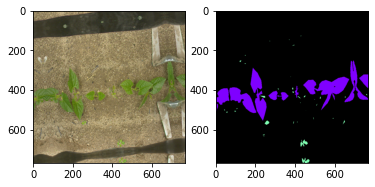

'\naugmented_img, target = next(iterator)\n\nrgb_img = cv2.imread(\'/content/Development_Dataset_15/training/images/Pead_mais_00070_i900.jpg\', cv2.IMREAD_UNCHANGED)  # open image\nproper_h = 384\nproper_w = 512\n    # resize to see how it works with kernels\n\n    # get exgreen\nexgr = None\nexgr_mask = None\nexgr = exgreen(rgb_img)\nprint("Exgr shape: ", exgr.shape)\n\nexgr_mask = thresh(exgr, 50)\n#exgr.resize([proper_h, proper_w, 3])\nim_gray_plt(exgr)\nim_gray_plt(exgr_mask)\n'

In [216]:
fig, ax = plt.subplots(1, 2)

augmented_img = augmented_img[1]   # First element
augmented_img = augmented_img  # denormalize

target = np.array(target[1, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()


'''
augmented_img, target = next(iterator)

rgb_img = cv2.imread('/content/Development_Dataset_15/training/images/Pead_mais_00070_i900.jpg', cv2.IMREAD_UNCHANGED)  # open image
proper_h = 384
proper_w = 512
    # resize to see how it works with kernels

    # get exgreen
exgr = None
exgr_mask = None
exgr = exgreen(rgb_img)
print("Exgr shape: ", exgr.shape)

exgr_mask = thresh(exgr, 50)
#exgr.resize([proper_h, proper_w, 3])
im_gray_plt(exgr)
im_gray_plt(exgr_mask)
'''

# Model setup

In [217]:
# -----------------------------------------------------------------
# Define the model created from scratch (without transfer learning)
# -----------------------------------------------------------------
def define_model(depth, start_f, num_classes, dynamic_input_shape, img_h, img_w):

    model = tf.keras.Sequential()
    
    # Encoder
    # -------
    for i in range(depth):
        
        if i == 0:
            if dynamic_input_shape:
                input_shape = [None, None, 3]
            else:
                input_shape = [img_h, img_w, 3]
        else:
            input_shape=[None]
        
        model.add(tf.keras.layers.Conv2D(filters=start_f, 
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same',
                                         input_shape=input_shape))
        model.add(tf.keras.layers.ReLU())
        model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

        start_f *= 2

    # Bottleneck => does not have pooling
    model.add(tf.keras.layers.Conv2D(filters=start_f, kernel_size=(3, 3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.ReLU())
    
    start_f = start_f // 2 # Start to decrease the number of features
        
    # Decoder: recover details
    # -------
    for i in range(depth):
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear')) # 2 means that double the input dimension
        # Now conv + ReLU transform the upsampled features into dense features
        model.add(tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same'))
        model.add(tf.keras.layers.ReLU())

        start_f = start_f // 2

    # Prediction Layer i.e. classification layer => FC layer convolutionalized
    # ----------------
    model.add(tf.keras.layers.Conv2D(filters=num_classes, # only 1 output neuron since the classification is binary: output => 0 == background, 1 == object
                                     kernel_size=(1, 1), # => FC layer convolutionalized
                                     strides=(1, 1), # stride of a FC layer
                                     padding='same', # or valid: kernel is (1,1) and stride (1,1) so is not important
                                     activation='softmax'))
    
    # Visualize created model as a table
    model.summary()

    return model

In [218]:
# -------------------------------------------------
# Define the unet model (without transfer learning)
# -------------------------------------------------
def define_unet(pretrained_weights, input_size):

    inputs = tf.keras.Input(input_size)

    conv1 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = tf.keras.layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = tf.keras.layers.Dropout(0.5)(conv5)

    up6 = tf.keras.layers.Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(drop5))
    merge6 = tf.keras.layers.concatenate([drop4,up6], axis = 3)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = tf.keras.layers.Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv6))
    merge7 = tf.keras.layers.concatenate([conv3,up7], axis = 3)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = tf.keras.layers.Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv7))
    merge8 = tf.keras.layers.concatenate([conv2,up8], axis = 3)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = tf.keras.layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv8))
    merge9 = tf.keras.layers.concatenate([conv1,up9], axis = 3)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = tf.keras.layers.Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    conv10 = tf.keras.layers.Conv2D(filters = 3, # only 1 output neuron since the classification is binary: output => 0 == background, 1 == object
                                    kernel_size = (1, 1), # => FC layer convolutionalized
                                    strides = (1, 1), # stride of a FC layer
                                    padding = 'same', # or valid: kernel is (1,1) and stride (1,1) so is not important
                                    activation='softmax')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    # Visualize created model as a table
    model.summary()

    return model

In [219]:
'''
model = unet()


model = create_model(depth=4, 
                     start_f=8, 
                     num_classes=3, 
                     dynamic_input_shape=False)
'''

'\nmodel = unet()\n\n\nmodel = create_model(depth=4, \n                     start_f=8, \n                     num_classes=3, \n                     dynamic_input_shape=False)\n'

In [220]:
# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):

  # get predicted class from softmax
  y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

  per_class_iou = []

  for i in range(1,3): # exclude the background class 0

    # Get prediction and target related to only a single class (i)
    class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
    class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
    intersection = tf.reduce_sum(class_true * class_pred)
    union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
    iou = (intersection + 1e-7) / (union + 1e-7)
    per_class_iou.append(iou)

  return tf.reduce_mean(per_class_iou)

In [221]:
# -----------------
# Compile the model
# -----------------
def compile_model(model, lr):

  # Optimization params
  # -------------------

  # Loss
  # ----
  # Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
  loss = tf.keras.losses.SparseCategoricalCrossentropy()
  # ----

  # Optimization function
  # ---------------------
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
  # ---------------------

  # Validation metrics
  # ------------------
  mIoU = meanIoU
  metrics = ['accuracy', mIoU]
  # ------------------

  # Compile Model
  # -------------
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  # -------------

  # -------------------
  
  return model

In [222]:
# -----------------
# Set the callbacks
# -----------------
def set_callbacks(type, model_checkpoint, visualize_tensorboard, early_stop, reduce_lr_on_plateau):
  
  import os
  from datetime import datetime

  cwd = os.getcwd()

  exps_dir = os.path.join('/content/drive/My Drive/Challenge_2/', 'segmentation_experiments')
  if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

  model_name = type

  exp_dir = os.path.join(exps_dir, model_name)
  if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
  callbacks = []

  # Model checkpoint
  # ----------------
  if model_checkpoint:
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                       save_weights_only=True,
                                                       save_best_only=True)  # False to save the model directly
    callbacks.append(ckpt_callback)
  # ----------------

  # Visualize Learning on Tensorboard
  # ---------------------------------
  if visualize_tensorboard:
    tb_dir = os.path.join(exp_dir, 'tb_logs')
    if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
    
    # By default shows losses and metrics for both training and validation
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                                 profile_batch=0,
                                                 histogram_freq=1)  # if 1 shows weights histograms
    callbacks.append(tb_callback)
  # ---------------------------------

  # Early Stopping
  # --------------
  if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                   patience = 10,
                                                   restore_best_weights=True)
    callbacks.append(es_callback)
  # --------------

  # Reduce Learning rate on plateau
  # -------------------------------
  if reduce_lr_on_plateau:
    rlr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                        factor=0.5, 
                                                        patience=4, 
                                                        verbose=1, 
                                                        mode='auto', 
                                                        min_delta=0.0001)
    callbacks.append(rlr_callback)
  # -------------------------------

  return callbacks

In [223]:
# -----------
# Train model
# -----------
def train_model(model, train_dataset, dataset, valid_dataset, dataset_valid, callbacks, num_epochs, bs):
  
  history_model = model.fit(x = train_dataset,
                            epochs = num_epochs,  #### set repeat in training dataset
                            steps_per_epoch = int(np.ceil(len(dataset) / bs)),
                            validation_data = valid_dataset,
                            validation_steps = int(np.ceil(len(dataset_valid) / bs)), 
                            callbacks = callbacks)
  
  return history_model

# Training

In [231]:
# --------------------------------------
# Train the model with transfer learning
# --------------------------------------
def train_unet():
  
  apply_data_augmentation = True

  img_h = 384
  img_w = 512

  num_classes = 3

  bs = 10

  lr = 5e-4

  num_epochs = 100

  model_checkpoint = True
  visualize_tensorboard = False
  early_stop = True
  reduce_lr_on_plateau = True

  print('--------------------------------------------')
  print('Image heigth                      ---> ' + str(img_h))
  print('Image width                       ---> ' + str(img_w))
  print('Batch size                        ---> ' + str(bs))
  print('Learning rate                     ---> ' + str(lr))
  print('Number of epochs                  ---> ' + str(num_epochs))
  print('Model checkpoint                  ---> ' + str(model_checkpoint))
  print('Visualize tensorboars             ---> ' + str(visualize_tensorboard))
  print('Early stopping                    ---> ' + str(early_stop))
  print('Reduce learning rate on plateau   ---> ' + str(reduce_lr_on_plateau))
  print('--------------------------------------------')

  [img_data_gen, mask_data_gen] = data_generator(apply_data_augmentation)

  [train_dataset, dataset, valid_dataset, dataset_valid] = create_dataset(img_data_gen, mask_data_gen, img_h = img_h, img_w = img_w, bs = bs, num_classes = num_classes)

  model = define_unet(pretrained_weights = None, input_size = (img_h, img_w, 3))
  '''
  exps_dir = os.path.join('/content/drive/My Drive/Challenge_2/', 'segmentation_experiments')
  model_name = 'CNN_Dec08_02-03-33'
  exp_dir = os.path.join(exps_dir, model_name)
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  latest = tf.train.latest_checkpoint(ckpt_dir)
  print(latest)
  model.load_weights(latest)
  '''

  '''
  model = define_model(depth = 5, 
                       start_f = 8, 
                       num_classes = num_classes, 
                       dynamic_input_shape=False,
                       img_h=img_h,
                       img_w=img_w)
  '''
  model = compile_model(model, lr = lr)

  callbacks = set_callbacks('unet', model_checkpoint = model_checkpoint, visualize_tensorboard = visualize_tensorboard, early_stop = early_stop, reduce_lr_on_plateau = reduce_lr_on_plateau)

  history = train_model(model, train_dataset, dataset, valid_dataset, dataset_valid, callbacks, num_epochs = num_epochs, bs = bs)

  plot_history(history)

  return model, history

# Plots

In [174]:
# ------------------------------------------------------------------------------
# Plot the history of the trained model (loss, val_loss; accuracy, val_accuracy)
# ------------------------------------------------------------------------------
def plot_history(history):
  from matplotlib import pyplot

  pyplot.figure()
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='test')
  pyplot.legend()
  pyplot.show()

  pyplot.figure()
  pyplot.plot(history.history['accuracy'], label='train')
  pyplot.plot(history.history['val_accuracy'], label='test')
  pyplot.legend()
  pyplot.show() 

# Execution

## Unet training

In [ ]:
[model, history] = train_unet()

--------------------------------------------
Image heigth                      ---> 384
Image width                       ---> 512
Batch size                        ---> 10
Learning rate                     ---> 0.0005
Number of epochs                  ---> 100
Model checkpoint                  ---> True
Visualize tensorboars             ---> False
Early stopping                    ---> True
Reduce learning rate on plateau   ---> True
--------------------------------------------
Model: "functional_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 384, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_412 (Conv2D)             (None, 384, 512, 64) 1792        input_17[0][0]                  

# Compute prediction

In [ ]:
import time
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline



iterator = iter(valid_dataset)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()
image, target = next(iterator)

image = image[0]
target = target[0, ..., 0]

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

# Get predicted class as the index corresponding to the maximum value in the vector probability
# predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
# predicted_class = predicted_class[0, ..., 0]
predicted_class = tf.argmax(out_sigmoid, -1)

out_sigmoid.shape

predicted_class = predicted_class[0, ...]

# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 21):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, 21):
  prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(prediction_img))

fig.canvas.draw()
time.sleep(1)

# Training

# Execution

# Result csv

In [ ]:
def rle_encode(img):
  '''
  img: numpy array, 1 - foreground, 0 - background
  Returns run length as string formatted
  '''
  pixels = img.flatten()
  pixels = np.concatenate([[0], pixels, [0]])
  runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
  runs[1::2] -= runs[::2]
  
  return ' '.join(str(x) for x in runs)

In [ ]:
import os
import json
import numpy as np
from PIL import Image

    # The submission file will be a zip file containing the a
    # submission.json file.

    # It must have the following structure:

    # - image name (without any extension, e.g., png, jpg, etc.)
    #   - shape: shape of the original image as list [Height, Width]
    #   - team: team of the original image. One in {'Bipbip', 'Pead', 'Roseau', 'Weedelec'}
    #   - crop: crop of the original image. One in {'Haricot', 'Mais'}
    #   - segmentation: prediction (as a dict)
    #     - crop: RLE encoded crop segmentation (no weed)
    #     - weed: RLE encoded weed segmentation (no crop)

    # Please refer to the folder structure of the given dataset to fill
    # the team and crop keys.

teams = ['Bipbip', 'Pead', 'Roseau', 'Weedelec']
plants = ['Haricot', 'Mais']

submission_dict = {}

for t in teams:
  for p in plants:

    tmp_path = '/content/Development_Dataset/Test_Dev/' + t + '/' + p + '/' + 'Images'
    
    image_filenames = os.listdir(tmp_path)

    for img_name in image_filenames:
      
      tmp_path = '/content/Development_Dataset/Test_Dev/' + t + '/' + p + '/' + 'Images'
      tmp_path = os.path.join(tmp_path, img_name)
      
      img_name = img_name.split('.')[0]

      submission_dict[img_name] = {}
      submission_dict[img_name]['shape'] = mask_arr.shape
      submission_dict[img_name]['team'] = t
      submission_dict[img_name]['crop'] = p
      submission_dict[img_name]['segmentation'] = {}

      img = Image.open(tmp_path).convert('RGB')
      #img = img.resize((img_h, img_w)) # ??????????????????????????????????????????????????????????????????

      img_array = np.array(img)
      img_array = np.expand_dims(img_array, 0) # insert batch dimension

      # Data Normalization
      img_array = img_array / 255.

      # Prediction from the model
      mask_arr = model.predict(x=img_array)

      # RLE encoding
      # crop
      rle_encoded_crop = rle_encode(mask_arr == 1)
      # weed
      rle_encoded_weed = rle_encode(mask_arr == 2)

      submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
      submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed

# Finally, save the results into the submission.json file
with open('/content/submission.json', 'w') as f:
  json.dump(submission_dict, f)

! mkdir '/content/drive/My Drive/Challenge_2/submission'
! cp '/content/submission.json' 

In [ ]:
! ls '/content/drive/My Drive/Challenge_2/submission'

In [ ]:
# ---------------------------------------
# Save the model trained with fine tuning
# ---------------------------------------
#! mkdir '/content/drive/My Drive/Challenge_1/model'
#! mkdir '/content/drive/My Drive/Challenge_1/model/EffNet_B7_dense_16_NOdropout_fine_tuning_block5-6-7'
#model.save('/content/drive/My Drive/Challenge_1/model/EffNet_B7_dense_16_NOdropout_fine_tuning_block5-6-7')

In [73]:
'''
Script to check dimension of the images

# -----------------------------------------------
teams = ['Bipbip', 'Pead', 'Roseau', 'Weedelec']
plants = ['Haricot', 'Mais']

submission_dict = {}

for t in teams:
  for p in plants:
    tmp_path = '/content/Development_Dataset/Test_Dev/' + t + '/' + p + '/' + 'Images'
    image_filenames = os.listdir(tmp_path)

    for img_name in image_filenames:

      tmp_path = '/content/Development_Dataset/Test_Dev/' + t + '/' + p + '/' + 'Images'
      tmp_path = os.path.join(tmp_path, str(img_name))
      
      img = Image.open(tmp_path).convert('RGB')
      img_array = np.array(img)

      img_name = img_name.split('.')[0]

      submission_dict[img_name] = {}
      submission_dict[img_name]['shape'] = img_array.shape
      submission_dict[img_name]['team'] = t
      submission_dict[img_name]['crop'] = p

# -----------------------------------------------------------------------
submission
'''